In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
spy_full = pd.read_csv('..\Data\spy_full.csv')
spy_week = pd.read_csv('..\Data\spy_week.csv')
spy_month = pd.read_csv('..\Data\spy_month.csv')

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Kaizu\AppData\Local\Temp\ipykernel_25512\1561699013.py:1: SyntaxWarning: invalid escape sequence '\D'
  spy_full = pd.read_csv('..\Data\spy_full.csv')
C:\Users\Kaizu\AppData\Local\Temp\ipykernel_25512\1561699013.py:2: SyntaxWarning: invalid escape sequence '\D'
  spy_week = pd.read_csv('..\Data\spy_week.csv')
C:\Users\Kaizu\AppData\Local\Temp\ipykernel_25512\1561699013.py:3: SyntaxWarning: invalid escape sequence '\D'
  spy_month = pd.read_csv('..\Data\spy_month.csv')


In [3]:
spy_full.head(), spy_week.head(), spy_month.head()

(   Unnamed: 0        date  adj_close  simple_return  log_return
 0           0  1993-01-29  24.608631            NaN         NaN
 1           1  1993-02-01  24.783640       0.007112    0.007087
 2           2  1993-02-02  24.836161       0.002119    0.002117
 3           3  1993-02-03  25.098705       0.010571    0.010516
 4           4  1993-02-04  25.203705       0.004183    0.004175,
          date  close_price  simple_return  log_return
 0  1993-02-07        24.78       0.007112    0.006884
 1  1993-02-14        25.19       0.000000    0.016410
 2  1993-02-21        24.35      -0.025228   -0.033915
 3  1993-02-28        24.49       0.003586    0.005733
 4  1993-03-07        24.80      -0.002815    0.012579,
          date  close_price  simple_return  log_return
 0  1993-02-01        24.78       0.007112    0.006884
 1  1993-03-01        24.80      -0.002815    0.000807
 2  1993-04-01        25.34      -0.003458    0.021541
 3  1993-05-01        24.94       0.006388   -0.015911
 4 

# Renaming columns to fit Prophet model

In [4]:
for df in [spy_full, spy_week, spy_month]:
    # Rename columns to fit Prophet requirements
    df.rename(columns={'date': 'ds', 'adj_close': 'y', 'close_price': 'y'}, inplace=True)
    
    # Ensure the 'ds' column is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])

    # Drop rows with missing target values
    df.dropna(subset=['y'], inplace=True)


In [5]:
print(spy_full.head())

   Unnamed: 0         ds          y  simple_return  log_return
0           0 1993-01-29  24.608631            NaN         NaN
1           1 1993-02-01  24.783640       0.007112    0.007087
2           2 1993-02-02  24.836161       0.002119    0.002117
3           3 1993-02-03  25.098705       0.010571    0.010516
4           4 1993-02-04  25.203705       0.004183    0.004175


# Initialising Prophet to fit the dataset

In [6]:
# Initiliasing the model
model = Prophet()

# Fitting model to full dataset
model.fit(spy_full)

timeframe = 365 * 20

# Creating a dataframe for future dates
future = model.make_future_dataframe(periods=timeframe)

# Predict future values
forecast_full = model.predict(future)

19:10:01 - cmdstanpy - INFO - Chain [1] start processing
19:10:09 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
print(forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

              ds         yhat  yhat_lower   yhat_upper
15315 2044-11-25  1429.648352  857.851489  2089.133664
15316 2044-11-26  1430.427694  848.144152  2093.692331
15317 2044-11-27  1430.481839  863.223369  2095.355648
15318 2044-11-28  1429.946874  849.904544  2095.464039
15319 2044-11-29  1429.920101  844.198406  2088.223445


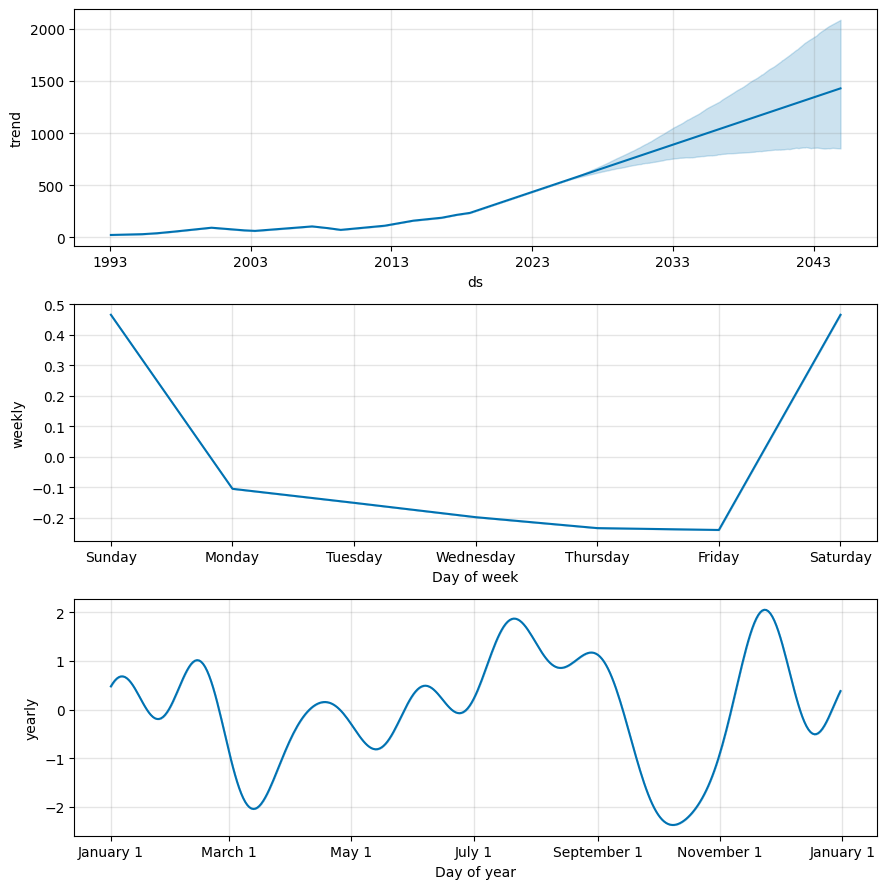

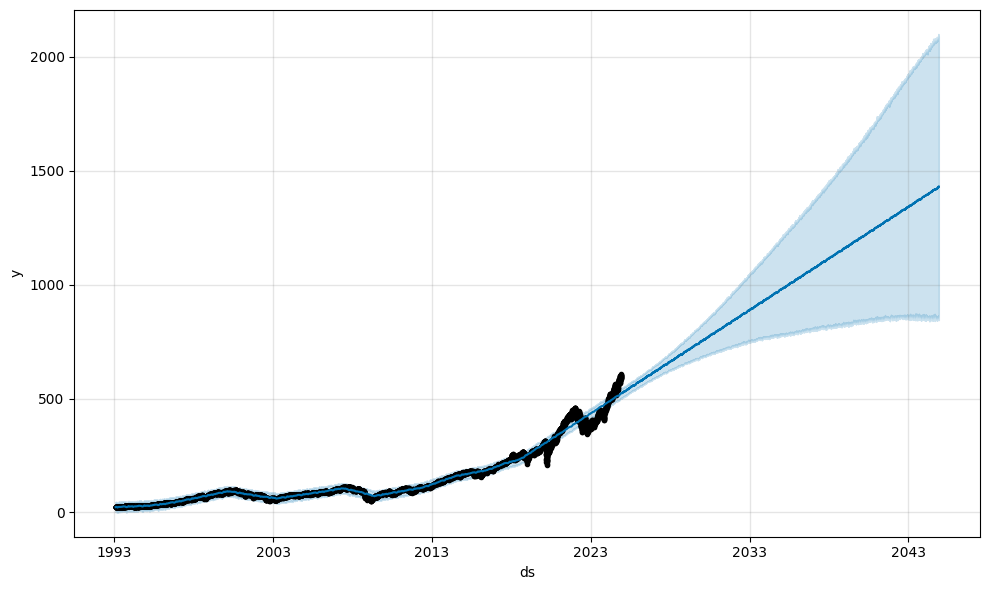

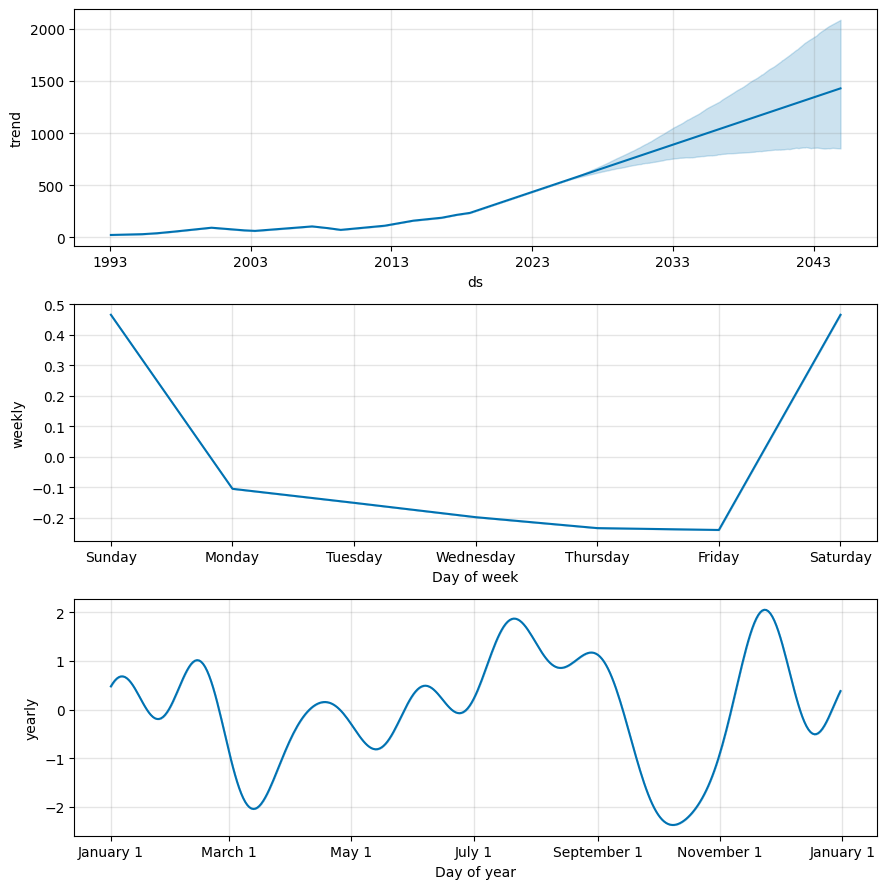

In [8]:
model.plot(forecast_full)
model.plot_components(forecast_full)

In [9]:
model2 = Prophet()
model2.fit(spy_week)
forecast_week = model2.predict(future)
print(forecast_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing


              ds         yhat   yhat_lower   yhat_upper
15315 2044-11-25  1423.685251  1053.104560  1765.052323
15316 2044-11-26  1423.906168  1053.826351  1765.501427
15317 2044-11-27  1424.112220  1054.863058  1766.884822
15318 2044-11-28  1424.301989  1062.202571  1763.384051
15319 2044-11-29  1424.474229  1060.530084  1769.570512


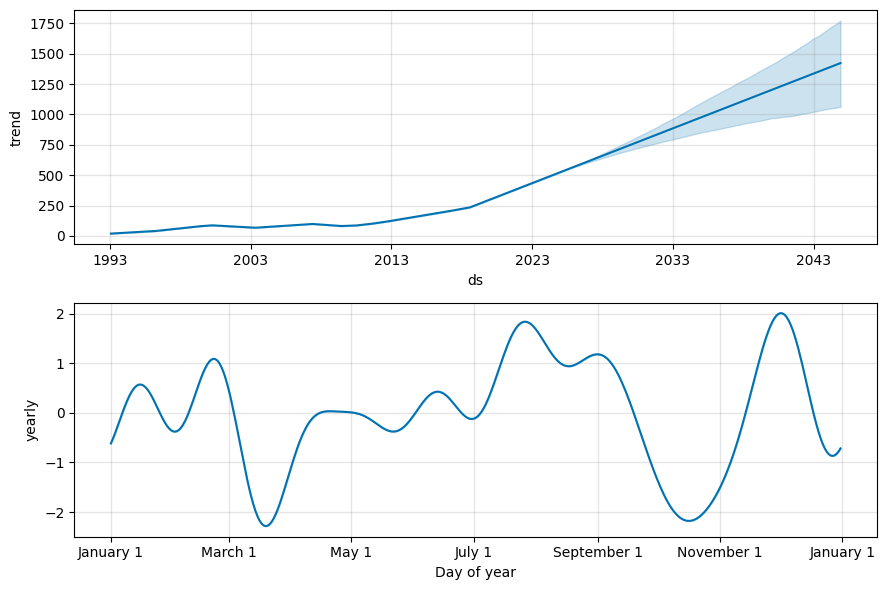

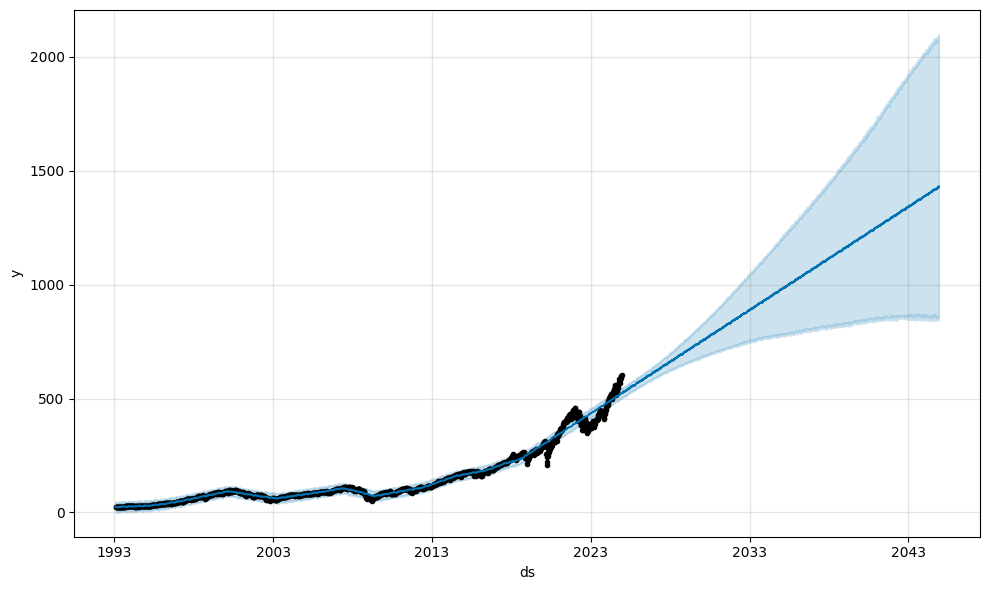

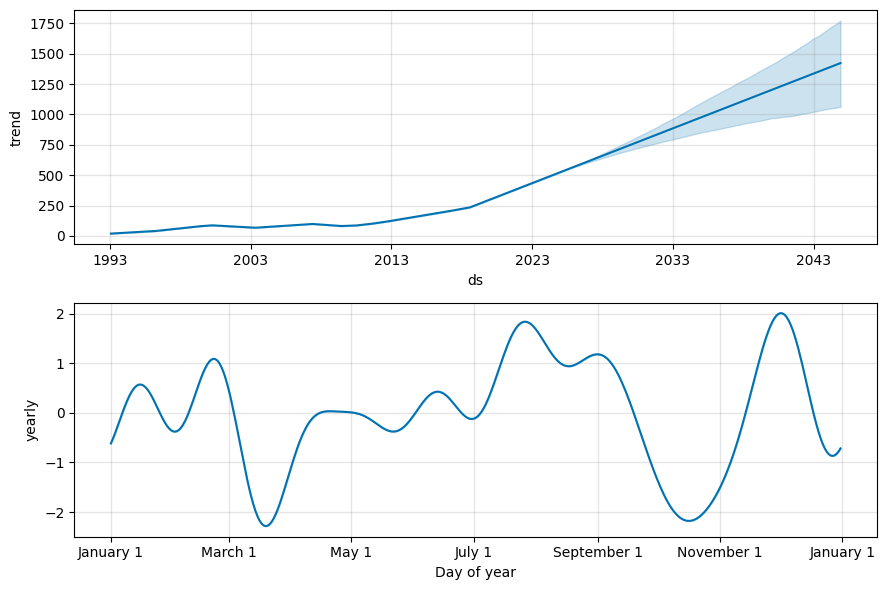

In [10]:
model2.plot(forecast_full)
model2.plot_components(forecast_week)

In [11]:
model3 = Prophet()
model3.fit(spy_month)
forecast_month = model3.predict(future)
print(forecast_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

19:10:20 - cmdstanpy - INFO - Chain [1] start processing
19:10:20 - cmdstanpy - INFO - Chain [1] done processing


              ds         yhat   yhat_lower   yhat_upper
15315 2044-11-25  1376.199779  1228.552777  1531.678537
15316 2044-11-26  1377.058948  1230.484815  1526.742439
15317 2044-11-27  1378.010366  1231.491823  1530.729081
15318 2044-11-28  1379.075765  1229.326281  1532.881222
15319 2044-11-29  1380.274902  1232.653162  1535.504850


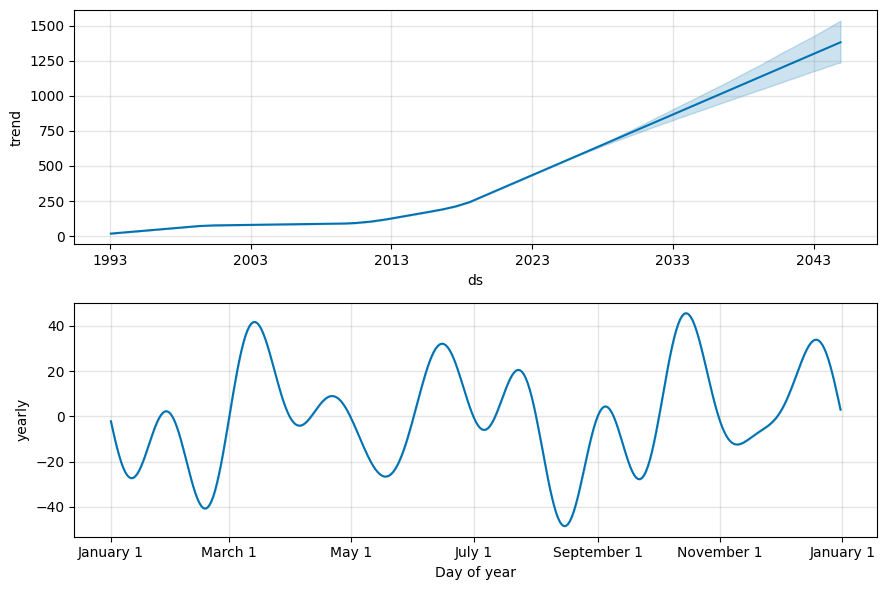

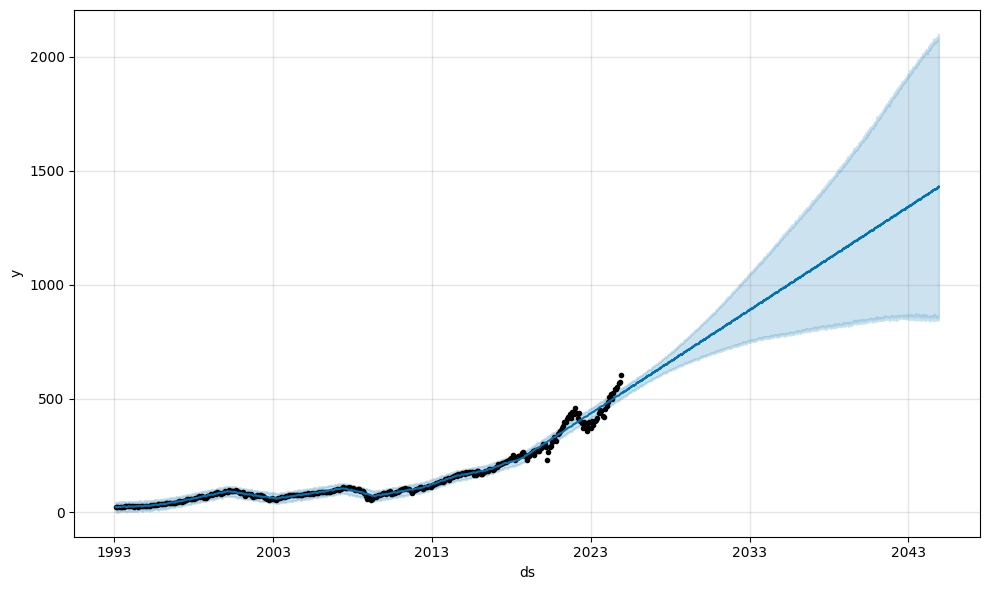

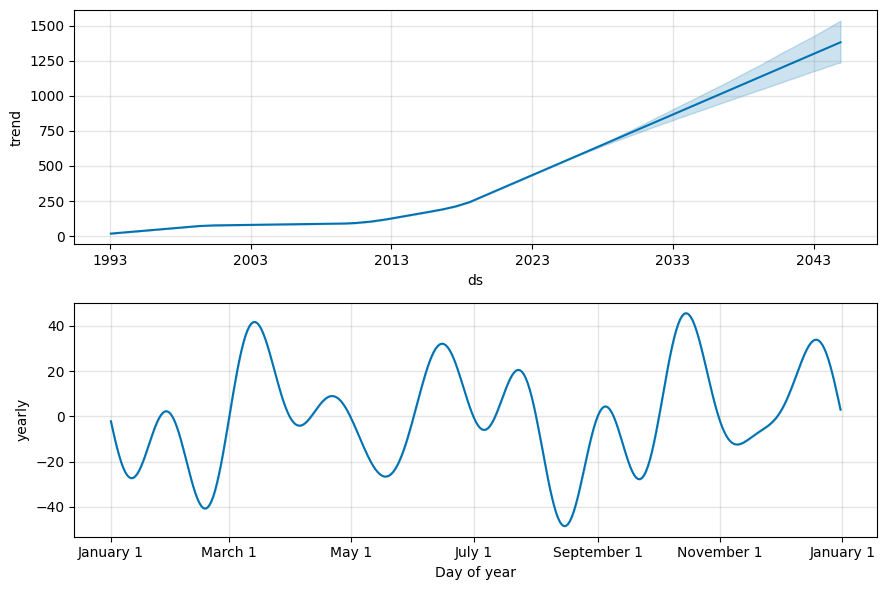

In [12]:
model3.plot(forecast_full)
model3.plot_components(forecast_month)

In [14]:
# Cross-validate the full dataset model
df_cv_full = cross_validation(model, initial='1095 days', period='365 days', horizon='365 days')
df_performance_full = performance_metrics(df_cv_full)
print("Full Dataset Performance:")
print(df_performance_full)

# Cross-validate the weekly dataset model
df_cv_weekly = cross_validation(model2, initial='1092 days', period='364 days', horizon='364 days')
df_performance_weekly = performance_metrics(df_cv_weekly)
print("Weekly Dataset Performance:")
print(df_performance_weekly)

# Cross-validate the monthly dataset model
df_cv_monthly = cross_validation(model3, initial='1098 days', period='366 days', horizon='366 days')
df_performance_monthly = performance_metrics(df_cv_monthly)
print("Monthly Dataset Performance:")
print(df_performance_monthly)

  0%|          | 0/28 [00:00<?, ?it/s]

19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:40 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:48 - cmdstanpy - INFO - Chain [1]

Full Dataset Performance:
     horizon          mse       rmse        mae      mape     mdape     smape  \
0    39 days   485.586902  22.036036  14.597826  0.091145  0.064608  0.089884   
1    40 days   484.948257  22.021541  14.568400  0.090458  0.064608  0.089263   
2    41 days   481.172225  21.935638  14.534002  0.090303  0.064288  0.089310   
3    42 days   475.529168  21.806631  14.481507  0.090398  0.064608  0.089650   
4    43 days   473.818202  21.767366  14.512851  0.091592  0.066463  0.090810   
..       ...          ...        ...        ...       ...       ...       ...   
322 361 days  1311.429093  36.213659  24.340660  0.160500  0.115807  0.159526   
323 362 days  1299.589350  36.049818  24.216205  0.160499  0.115004  0.159548   
324 363 days  1313.213516  36.238288  24.339275  0.160623  0.117794  0.160427   
325 364 days  1313.429496  36.241268  24.360144  0.160492  0.115807  0.160650   
326 365 days  1314.365492  36.254179  24.396311  0.161693  0.116520  0.161429   

 

  0%|          | 0/28 [00:00<?, ?it/s]

19:16:59 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing
19:16:59 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1]

Weekly Dataset Performance:
    horizon          mse       rmse        mae      mape     mdape     smape  \
0   42 days   517.362203  22.745597  15.518953  0.098987  0.077375  0.097537   
1   49 days   512.504933  22.638572  15.586566  0.100564  0.080424  0.099052   
2   56 days   493.278594  22.209876  15.529095  0.102674  0.072251  0.100711   
3   63 days   477.132544  21.843364  15.562387  0.105179  0.068594  0.102911   
4   70 days   471.836901  21.721807  15.718461  0.109884  0.076829  0.106810   
5   77 days   471.639373  21.717260  15.900318  0.115046  0.076829  0.110752   
6   84 days   481.776285  21.949403  16.072021  0.118168  0.073777  0.113125   
7   91 days   483.460769  21.987741  16.179444  0.119743  0.075480  0.114816   
8   98 days   516.553226  22.727807  16.555615  0.122090  0.077550  0.117162   
9  105 days   558.402513  23.630542  16.957176  0.122446  0.077550  0.118160   
10 112 days   586.317075  24.213985  17.229697  0.120656  0.077724  0.117851   
11 119 days 

  0%|          | 0/28 [00:00<?, ?it/s]

19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:10 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1]

Monthly Dataset Performance:
     horizon          mse       rmse        mae      mape     mdape     smape  \
0    35 days   817.206941  28.586832  19.547827  0.109736  0.079685  0.108076   
1    36 days   818.864179  28.615803  19.587520  0.110897  0.082048  0.109403   
2    37 days   652.229677  25.538788  16.919535  0.104926  0.061860  0.102858   
3    38 days   626.059281  25.021177  16.577926  0.105657  0.079685  0.103647   
4    39 days   657.745727  25.646554  17.401801  0.111560  0.082048  0.110343   
..       ...          ...        ...        ...       ...       ...       ...   
225 353 days  1298.607472  36.036197  26.686516  0.217039  0.190515  0.220926   
226 354 days  1262.386538  35.530079  25.491052  0.201222  0.179702  0.201069   
227 355 days  1240.838030  35.225531  24.816329  0.192098  0.168428  0.189373   
228 356 days  1237.259636  35.174702  24.666223  0.189299  0.161471  0.187870   
229 366 days  1651.065525  40.633306  27.084659  0.176342  0.161471  0.179706   

# Why This Matters

Each dataset has a different frequency (daily, weekly, monthly), so the cross-validation parameters must align with the nature of the data. Otherwise:

Using daily settings for weekly/monthly data results in too few or mismatched splits.
Weekly and monthly models will have fewer data points, so the time periods need to be adjusted accordingly.

# Understanding Prophet's Cross-Validation Parameters
1. initial
- Defines the initial training period, i.e., how much historical data to use for training in the first fold.
- It specifies how far back in time the training data starts relative to the earliest validation period.
- For example:
If initial='1095 days', the model is trained on the first 3 years of data before starting validation.

2. horizon
- Defines the forecast horizon, i.e., how far into the future the model is evaluated for predictions.
- Determines the length of the validation period.
- For example:
If horizon='365 days', the model's predictions are compared against the actual values 1 year (365 days) into the future.

3. period
- Defines the gap between successive validation cutoffs.
- It controls how often the training window is moved forward for the next validation.
- For example:
If period='365 days', the validation is performed every 1 year.

# How Cross-Validation Works in Prophet
## Prophet uses rolling origin cross-validation, which evaluates the model on successive validation sets as the training window shifts forward.

### Here’s a step-by-step example:

#### Setup
- Dataset: Historical data with daily frequency.
- Parameters:
    1. initial='1095 days': Use the first 3 years for training.
    2. horizon='365 days': Evaluate 1-year forecasts.
    3. period='365 days': Shift the training window by 1 year for each fold.


# Metrics from Cross-Validation
- *mse* (Mean Squared Error): Measures average squared error.
- *rmse* (Root Mean Squared Error): Error magnitude in the same unit as the target.
- *mae* (Mean Absolute Error): Average absolute error.
- *coverage*: Proportion of actual values within prediction intervals.
